# Handwritten Digit Recognition using Softmax Regression ( Multiclass ) 
Goal : train a model to correctly classify images of handwritten digits (from 0-9) based on pixel values using the dataset provided by MNIST 

In [ ]:
import numpy as np # a package for scientific computing
import tensorflow as tf # a platform for machine learning
import matplotlib.pyplot as plt # a library to plot graphs

# keras is an api built into tenserflow to design, train and implement NNs 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid



# Loading data from the data Folder

In [6]:
def load_data():
    X = np.load("data/X.npy")
    y = np.load("data/y.npy")
    return X, y

- The first part of the training set contains 5000 training examples of handwritten digits provided by MNIST
  - Each training example is a 20-pixel x 20-pixel grayscale image of the digit.
  - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location.
  - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.
  - This gives us a 5000 x 400 matrix X where every row is a training example of a handwritten digit image.
- The second part of the training set is a 5000 x 1 dimensional vector y that contains labels for the training set

In [7]:
X, y = load_data()

In [11]:
print(f' This row \n {X[0]} \n is a vectorized presentation of a picture for the number : {y[0,0]}')   

 This row 
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e

# Ploating a batch of 64 training examples 

this is a a batch of 64 random training examples


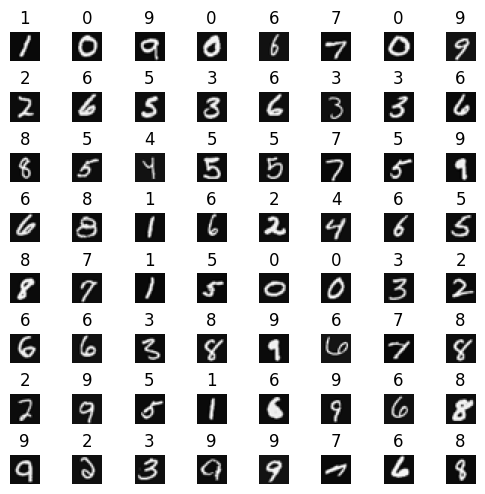

In [18]:

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 1]) #[left, bottom, right, top]
print('this is a a batch of 64 random training examples')
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image so we dont get an inverted one 
    X_random_reshaped = X[random_index].reshape((20,20)).T 
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()


# Neural Netwrork Architecture 

In [19]:
tf.random.set_seed(1234) # for consistent results 
model = Sequential(
    [               
        Dense(units = 25 ,activation = 'relu',input_shape=(400,), name = "L1"),
        Dense(units = 15 ,activation = 'relu', name = "L2"),
        Dense(units = 10 ,activation = 'linear', name = "L3") 
        # The numerical stability will be improved if the softmax is grouped with the loss function 
        # Therfore, it's better to use the Linear activation in the ouput layer
    ], name = "my_model" 
)
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 25)                10025     
                                                                 
 L2 (Dense)                  (None, 15)                390       
                                                                 
 L3 (Dense)                  (None, 10)                160       
                                                                 
Total params: 10575 (41.31 KB)
Trainable params: 10575 (41.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Weights and Biases shapes examination 
[layer1, layer2, layer3] = model.layers 
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()

print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


- ps : the bias shape (n,) is a convetion used in tf, it's the same as (1, n) 

# Neural network training 

- Handwritten digits recognition is a multiclass classification problem, therefore we will use Softmax Regression  
Normally, the SparseCategoricalCrossentropy function expects predicted probabilities as input. It compares these probabilities to the true labels to compute the loss.  
- Knowing that the neural network will produce unnormalized values that can be positive, negative, or zero ( not probabalities ) since we used a Linear Activation in the ouput layer and not a Softmax Activation we will train the model using the SparseCategoricalCrossentropy function, while from_logits=True, this will internally apply the softmax activation function to the logits before computing the loss. This ensures that the logits are transformed into valid probabilities while making my model training more numerically stable
- Using the Adaptive Moment Estimation Optimization Algorithm adapts the learning rate to ensure fast convergence of the loss
- The number of epochs was set to 40, this means that the entire data set should be applied during training 40 times.
- For efficiency, the training data set is broken into 'batches',The default size of a batch in Tensorflow is 32. There are 5000 examples in our data set or roughly 157 batches



In [23]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

In [25]:
history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 2/40
157/157 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 3/40
157/157 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 4/40
157/157 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 5/40
157/157 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 6/40
157/157 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7/40
157/157 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 8/40
157/157 [==============================] - 0s 2ms/step - loss: 9.4960e-04
Epoch 9/40
157/157 [==============================] - 0s 2ms/step - loss: 9.0794e-04
Epoch 10/40
157/157 [==============================] - 0s 2ms/step - loss: 8.6339e-04
Epoch 11/40
157/157 [==============================] - 0s 2ms/step - loss: 8.1184e-04
Epoch 12/40
157/157 [==============================] - 0s 3ms/step - loss: 7.8970e-04
Epoch

### Let's compare the predictions vs the labels for a random sample of 16 Handwritten digits.

1/1 [==============================] - 0s 31ms/step


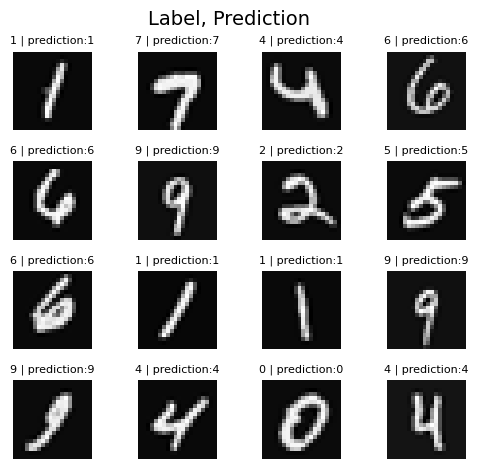

In [37]:

m, n = X.shape

fig, axes = plt.subplots(4,4, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20,20)).T


    
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400)) # predict() returns an array of unormalised values 
    prediction_p = tf.nn.softmax(prediction) # applying softmax
    yhat = np.argmax(prediction_p) # getting the index of the element with the higher probability
    
    ax.set_title(f"{y[random_index,0]} | prediction:{yhat}",fontsize=8)
    ax.imshow(X_random_reshaped, cmap='gray')
    ax.set_axis_off()
    
fig.suptitle("Label, Prediction", fontsize=14)
plt.show()